<a href="https://colab.research.google.com/github/BrendaGonzales757/ExamenFinal/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#instalación del entorno TradingEnv
!pip install gym-anytrading

In [2]:
#crear entorno
import gymnasium as gym
import gym_anytrading

In [3]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

custom_env= gym.make('forex-v0', df= FOREX_EURUSD_1H_ASK,
                     window_size=10,
                     frame_bound=(10,300),
                     unit_side='right'
                     )


In [4]:
print()
print("custom_env information:")
print("> shape:", custom_env.unwrapped.shape)
print("> df.shape:", custom_env.unwrapped.df.shape)
print("> prices.shape:", custom_env.unwrapped.prices.shape)
print("> signal_features.shape:", custom_env.unwrapped.signal_features.shape)
print("> max_possible_profit:", custom_env.unwrapped.max_possible_profit())


custom_env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 1.1228998536878634


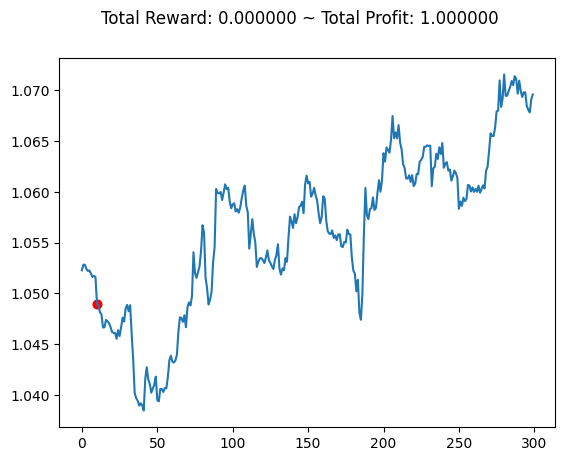

In [5]:
custom_env.reset()
custom_env.render()

info: {'total_reward': 34.90567207336426, 'total_profit': 0.9812550141049676, 'position': <Positions.Short: 0>}


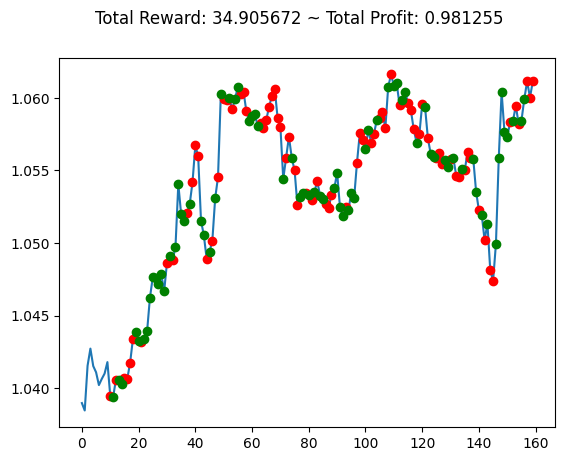

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL


env = gym.make('forex-v0', frame_bound=(50, 200), window_size=10)

observation = env.reset(seed=42)
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated #reward=27.89

    if done:
        print("info:", info)
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

In [18]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch

In [19]:
env_name = 'stocks-v0'  # or 'forex-v0'
env = gym.make(env_name)

In [24]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max

class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')


        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:

        if vec_env:
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                break

        reward_over_episodes.append(total_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes

In [21]:
seed = 42  # random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]


model_class_list = [A2C, PPO]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases

        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')


        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min, avg, max, = print_stats(rewards)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}

        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : stocks-v0
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: 284.550: 100%|██████████| 50/50 [00:01<00:00, 32.29it/s]


Min. Reward          :    284.550
Avg. Reward          :    284.550
Max. Reward          :    284.550
--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Reward: 566.204: 100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


Min. Reward          :     60.143
Avg. Reward          :    550.552
Max. Reward          :    963.165
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [00:49, 542.01it/s]
Episode: 40, Avg. Reward: 648.089: 100%|██████████| 50/50 [01:35<00:00,  1.91s/it]

Min. Reward          :    368.479
Avg. Reward          :    652.690
Max. Reward          :   1132.637


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook.py:1762: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



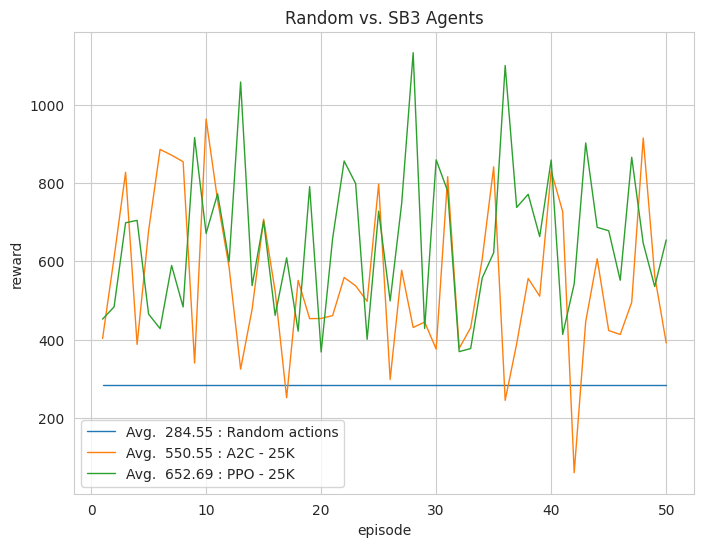

In [23]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()